In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import ast 
from matplotlib.lines import Line2D

In [2]:
#matplotlib.rcParams['font.family'] = "sans-serif"
#matplotlib.rcParams['font.sans-serif'] = "Arial"

smaller_size = 13
medium_size = 14
bigger_size = 16

plt.rc('font', size=bigger_size)          # controls default text sizes
plt.rc('axes', titlesize=medium_size)     # fontsize of the axes title
plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=smaller_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=smaller_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=smaller_size)    # legend fontsize
plt.rc('figure', titlesize=bigger_size)  # fontsize of the figure title


In [20]:
# Choose an experiment id and move one of the index folder here
root = "/users/ngun7t/Documents/cellbox-jun-6/manuscript_rep/Figure2"
os.chdir(root)

base_result_dir = "/data/weirauchlab/team/ngun7t/cellbox_results/results"
id = "Pytorch_RP_fig2_rep_5thattempt_18b9f662238ffa48b9457ee6d5b5f90f" 
index='150'

import shutil
shutil.copytree(
    os.path.join(base_result_dir, id, f"seed_{index}"),
    os.path.join(root, f"seed_{index}")
)

'/users/ngun7t/Documents/cellbox-jun-6/manuscript_rep/Figure2/seed_150'

In [21]:
# Panel A
root = "/users/ngun7t/Documents/cellbox-jun-6/manuscript_rep/Figure2"
os.chdir(root)
#index = '680' # or 035 which are non-oscillating models
#loss = pd.read_csv('b11_'+index+'/record_eval.csv')
loss = pd.read_csv('seed_'+index+'/record_eval.csv',usecols=range(8))
noi_index = np.genfromtxt("/users/ngun7t/Documents/cellbox-jun-6/data/node_Index.csv", 
                          dtype = str)[[2,3,82,31,40,83]]

In [22]:
# Panel B
def _simu(t_mu, W, alpha, eps, x_0 = np.zeros([99]), dT=0.1, n_T=100):
    def _dXdt(x):
        dXdt = eps[:, 0] * np.tanh(np.matmul(W, x) + t_mu) - alpha[:, 0] * x
        return dXdt
    
    x = x_0
    trace = x_0
    for i in range(n_T):
        """ Integrate with Heun's Method """
        dXdt_current = _dXdt(x)
        dXdt_next = _dXdt(x + dT * dXdt_current)
        x = x + dT * 0.5 * (dXdt_current + dXdt_next)
        trace = np.append(trace,x)
    trace = np.reshape(trace, [n_T+1, 99])
    return trace
def b(index = '000', condition = 0, nT = 400):

    #os.chdir(root+'/b11_'+index)
    os.chdir(root+'/seed_'+index)

#     alpha = pd.read_csv(glob.glob('*%d*json.4*alpha*csv'%nT)[0], index_col = 0).values
#     eps = pd.read_csv(glob.glob('*%d*json.4*eps*csv'%nT)[0], index_col = 0).values
#     w = pd.read_csv(glob.glob('*%d*json.4*W*csv'%nT)[0], index_col = 0).values
    alpha = pd.read_csv(glob.glob('6_best.params.alpha*csv')[0], index_col = 0).values
    eps = pd.read_csv(glob.glob('6_best.params.eps*csv')[0], index_col = 0).values
    w = pd.read_csv(glob.glob('6_best.params.W*csv')[0], index_col = 0).values

    pert = np.genfromtxt('/users/ngun7t/Documents/cellbox-jun-6/data/pert.csv', dtype = np.float32, delimiter = ',')
    expr = np.genfromtxt('/users/ngun7t/Documents/cellbox-jun-6/data/expr.csv', dtype = np.float32, delimiter = ',')
    pos = np.genfromtxt('random_pos.csv')

    noi = [2,3,31,40,82,83]
    trace = _simu(pert[condition], w, alpha, eps, n_T = int(nT))
    trace_subset = trace[:,noi].transpose()
    xs = np.linspace(0, nT/10, int(nT)+1)
    real = expr[condition, noi]

    for t, trace_i in enumerate(trace_subset):
        plt.axhline(y = real[t], xmax = 0.98, ls="dashed",  alpha = 0.8,
                    color = sns.color_palette("deep")[t])
                    
        plt.plot(xs, trace_i, color = sns.color_palette("deep")[t], 
                 label = noi_index[t], alpha = 0.8)


    #plt.axvline(x = nT/10, color="black", ls="dashed", alpha = 0.8, linewidth=2)
    return trace, real

In [23]:
# Panel C
#y_hat = pd.read_csv(root+'/12_random_partition_average_testhat.csv', index_col = 0)
y_hat = pd.read_csv("/users/ngun7t/Documents/cellbox-jun-6/manuscript_rep/Figure2/random_partition_average_pytorch_500_Aug8-23.csv", index_col = 0)
y = pd.read_csv("/users/ngun7t/Documents/cellbox-jun-6/data/expr.csv", header = None)

In [24]:
def moving_average(sequence, n=5) :
    ret = np.cumsum(sequence, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

/tmp/ipykernel_106260/2454332376.py:119: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


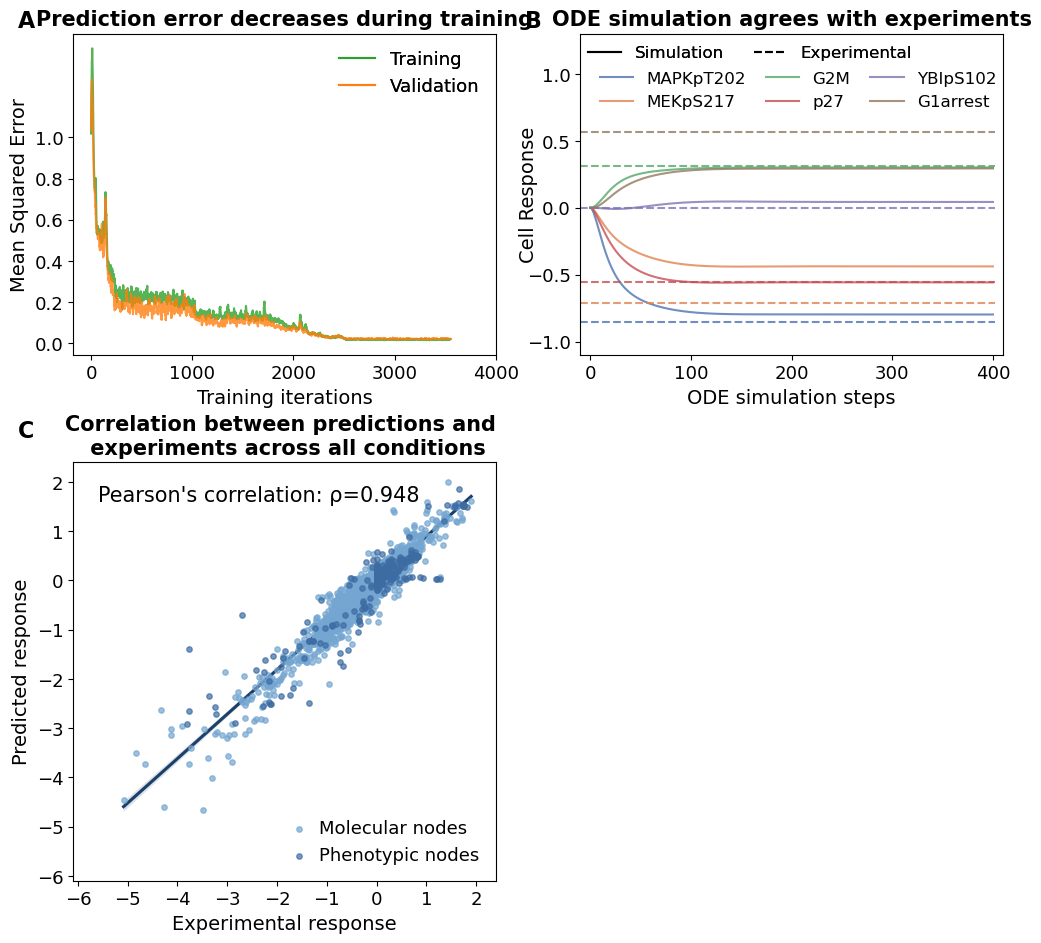

In [27]:
# Combined plot
f, axes = plt.subplots(figsize = [12, 11])

# Panel A
ax = plt.subplot2grid((5, 2), (0, 0), rowspan=2)
nma = 10
idx = np.where([x!='None' for x in loss['train_mse']])[0]
plt.plot(np.arange(len(idx)-nma+1), 
         moving_average(np.array([float(x) for x in loss['train_mse'][idx]]),n=nma), 
         alpha = 0.8, color="C2")
plt.plot(np.arange(len(idx)-nma+1), 
         moving_average(np.array([float(x) for x in loss['valid_mse'][idx]]),n=nma), 
         alpha = 0.8, color="C1")
#plt.plot(np.arange(len(idx)-nma+1), 
#         moving_average(np.array([float(x) for x in loss['test_mse'][idx]]),n=nma), 
#         alpha = 0.8, color="C0")
plt.xlabel('Training iterations')
plt.ylabel('Mean Squared Error')
#custom_lines = [Line2D([0], [0], color='C2'), 
#                Line2D([0], [0], color='C1'),
#                Line2D([0], [0], color='C0')]
#legend = plt.legend(custom_lines, ['Training', 'Validation', 'Test'], loc='upper right',
#                    frameon=False)
custom_lines = [Line2D([0], [0], color='C2'), 
                Line2D([0], [0], color='C1')]
legend = plt.legend(custom_lines, ['Training', 'Validation'], loc='upper right',
                    frameon=False)
ax.add_artist(legend)
#plt.legend(['Training', 'Validation', 'Test'], frameon=False)
plt.xticks([0,1000,2000,3000,4000])
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
plt.title("Prediction error decreases during training", 
          weight='bold', size=15)
plt.text(-0.13,1.02,'A', weight='bold',transform=ax.transAxes)

# Panel B
ax = plt.subplot2grid((5, 2), (0, 1), rowspan=2)
trace, real = b(index = index, condition = 0, nT = 400)
#plt.axvline(x = 40, ymin=0.03, ymax=0.73, color="black", ls="dashed", alpha = 0.8, linewidth=2)
plt.xlabel('ODE simulation steps')
plt.ylabel('Cell Response', labelpad=-8)
plt.xlim([-1,41])
plt.ylim([-1.1,1.3])
plt.xticks([0,10,20,30,40],[0,100,200,300,400])
plt.yticks([-1,-0.5,0,0.5,1.0])

custom_lines = [Line2D([0], [0], color='k'), Line2D([0], [0], color='k', ls="dashed")]
legend1 = plt.legend(loc='upper right', bbox_to_anchor=(1.02, 0.93), frameon=False, 
                     ncol=3, prop={'size': 12, "weight": "normal"}, columnspacing=1.2)
legend2 = plt.legend(custom_lines, ['Simulation', 'Experimental'], loc='upper right',
                     ncol=2, bbox_to_anchor=(0.82, 1.01), frameon=False, 
                     prop={'size': 12,'style':'normal','weight':'normal','variant':'normal','stretch':'normal'},
                     columnspacing=1.8)
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.title("ODE simulation agrees with experiments", 
          weight='bold', size=15)
plt.text(-0.13,1.02,'B', weight='bold',transform=ax.transAxes)


# Panel C
ax = plt.subplot2grid((14, 2), (7, 0), rowspan=8)
x_all = y.values.flatten()
y_all = y_hat.values.flatten()

x_prot = y.iloc[:,0:82]
y_prot = y_hat.iloc[:,0:82]
x_pheno = y.iloc[:,82:87]
y_pheno = y_hat.iloc[:,82:87]
plt.scatter(x_prot, y_prot, s = 15, alpha = 0.7, color="#74A6D1",zorder=3)
#plt.scatter(x_prot, y_prot, s = 15, alpha = 0.7, color="#FC5A5B",zorder=3)
plt.scatter(x_pheno, y_pheno, s = 15, alpha = 0.7, color="#3D6CA3",zorder=4)
#plt.scatter(x_pheno, y_pheno, s = 15, alpha = 0.7, color="#FECD7F",zorder=4)
plt.legend(["Molecular nodes","Phenotypic nodes"], loc="lower right", frameon=False,
          handletextpad=0.1)
plt.plot([-10, 10], [-10, 10], c = 'white', alpha = 0, ls = '--')
#plt.scatter(x_all, y_all, s = 15, alpha = 0.6)
sns.regplot(x=x_all, y=y_all, scatter_kws={'s': 15, 'alpha': 0},line_kws={'color': '#1B406C', 'alpha': 1})
#sns.regplot(x_all, y_all, scatter_kws={'s': 15, 'alpha': 0},line_kws={'color': '#F18A64', 'alpha': 1})

plt.xticks(np.arange(-6,3))
plt.yticks(np.arange(-6,3))
#plt.grid(True, which='both')

lower = np.min([x_all, y_all])
upper = np.max([x_all, y_all])
plt.xlim([lower*1.2, upper*1.2])
plt.ylim([lower*1.2, upper*1.2])

r = np.corrcoef(x_all, y_all)[0][1]
plt.text(x = -5.6, y= 1.6, s='Pearson\'s correlation: ρ=%1.3f'%r,
        size = 15)
plt.xlabel('Experimental response')
plt.ylabel('Predicted response')
plt.title("Correlation between predictions and \n experiments across all conditions", 
          weight='bold', size=15)

plt.text(-0.13,1.06,'C', weight='bold',transform=ax.transAxes)
"""

# Panel D (across different conditions)
ax = plt.subplot2grid((14, 2), (7, 1), rowspan=8)
x_all = y.values
y_all = y_hat.values
rs = [np.corrcoef(x_all[i], y_all[i])[0][1] for i in range(y.shape[0])]
plt.hist(rs, bins = 22, color = 'grey', alpha = 0.6, rwidth=0.93)
plt.axvline(x = r, linewidth=2, label = 'Median', color="#1B406C")
plt.xlabel('Experiment-prediction correlation')
plt.ylabel('Number of conditions')
plt.xticks([0.2,0.4,0.6,0.8,1.0])
plt.yticks([0,10,20,30,40])
plt.text(0.62,33,"correlation for \nall conditions", color="#1B406C",
        size = 15)
plt.title("Correlation between predictions and \n experiments for individual conditions", 
          weight='bold', size=15)
plt.text(-0.13,1.06,'D', weight='bold',transform=ax.transAxes)
"""

plt.tight_layout()
plt.savefig("/users/ngun7t/Documents/cellbox-jun-6/manuscript_rep/Figure2/Figure2_replication.png")


Text(0.5, 1.0, 'Correlation between predictions and \n experiments across all conditions')

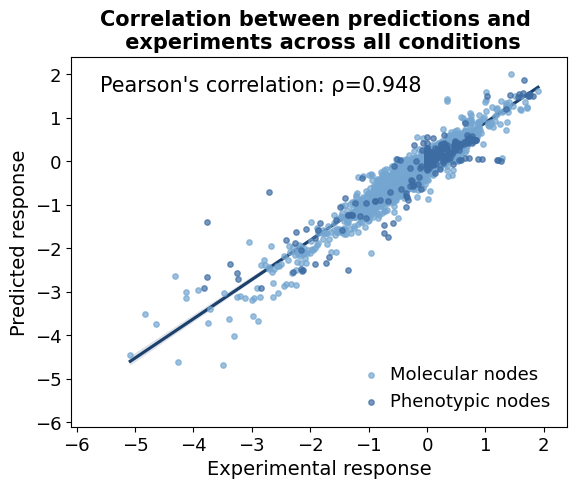

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1)
x_all = y.values.flatten()
y_all = y_hat.values.flatten()

x_prot = y.iloc[:,0:82]
y_prot = y_hat.iloc[:,0:82]
x_pheno = y.iloc[:,82:87]
y_pheno = y_hat.iloc[:,82:87]
plt.scatter(x_prot, y_prot, s = 15, alpha = 0.7, color="#74A6D1",zorder=3)
#plt.scatter(x_prot, y_prot, s = 15, alpha = 0.7, color="#FC5A5B",zorder=3)
plt.scatter(x_pheno, y_pheno, s = 15, alpha = 0.7, color="#3D6CA3",zorder=4)
#plt.scatter(x_pheno, y_pheno, s = 15, alpha = 0.7, color="#FECD7F",zorder=4)
plt.legend(["Molecular nodes","Phenotypic nodes"], loc="lower right", frameon=False,
          handletextpad=0.1)
plt.plot([-10, 10], [-10, 10], c = 'white', alpha = 0, ls = '--')
#plt.scatter(x_all, y_all, s = 15, alpha = 0.6)
sns.regplot(x=x_all, y=y_all, scatter_kws={'s': 15, 'alpha': 0},line_kws={'color': '#1B406C', 'alpha': 1})
#sns.regplot(x_all, y_all, scatter_kws={'s': 15, 'alpha': 0},line_kws={'color': '#F18A64', 'alpha': 1})

plt.xticks(np.arange(-6,3))
plt.yticks(np.arange(-6,3))
#plt.grid(True, which='both')

lower = np.min([x_all, y_all])
upper = np.max([x_all, y_all])
plt.xlim([lower*1.2, upper*1.2])
plt.ylim([lower*1.2, upper*1.2])

r = np.corrcoef(x_all, y_all)[0][1]
plt.text(x = -5.6, y= 1.6, s='Pearson\'s correlation: ρ=%1.3f'%r,
        size = 15)
plt.xlabel('Experimental response')
plt.ylabel('Predicted response')
plt.title("Correlation between predictions and \n experiments across all conditions", 
          weight='bold', size=15)

#plt.text(-0.13,1.06,'C', weight='bold',transform=ax[0].transAxes)

Text(0, 0.5, 'Predicted response')

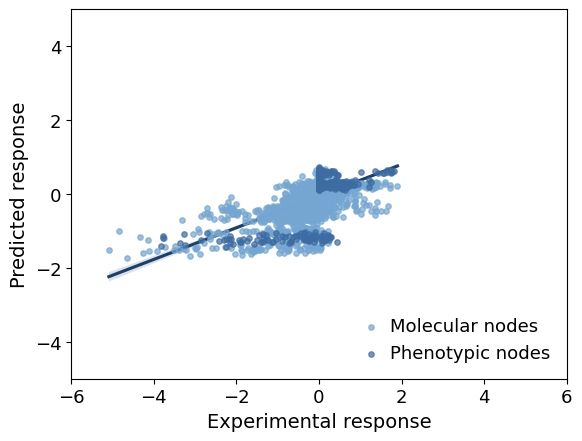

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1)
x_all = y.values.flatten()
y_all = y_hat.values.flatten()

x_prot = y.iloc[:,0:82]
y_prot = y_hat.iloc[:,0:82]
x_pheno = y.iloc[:,82:87]
y_pheno = y_hat.iloc[:,82:87]
plt.scatter(x_prot, y_prot, s = 15, alpha = 0.7, color="#74A6D1",zorder=3)
#plt.scatter(x_prot, y_prot, s = 15, alpha = 0.7, color="#FC5A5B",zorder=3)
plt.scatter(x_pheno, y_pheno, s = 15, alpha = 0.7, color="#3D6CA3",zorder=4)
#plt.scatter(x_pheno, y_pheno, s = 15, alpha = 0.7, color="#FECD7F",zorder=4)
plt.legend(["Molecular nodes","Phenotypic nodes"], loc="lower right", frameon=False,
          handletextpad=0.1)
plt.plot([-10, 10], [-10, 10], c = 'white', alpha = 0, ls = '--')
#plt.scatter(x_all, y_all, s = 15, alpha = 0.6)
sns.regplot(x=x_all, y=y_all, scatter_kws={'s': 15, 'alpha': 0},line_kws={'color': '#1B406C', 'alpha': 1})
#sns.regplot(x_all, y_all, scatter_kws={'s': 15, 'alpha': 0},line_kws={'color': '#F18A64', 'alpha': 1})

lower = np.min([x_all, y_all])
upper = np.max([x_all, y_all])
plt.xlim([-6, 6])
plt.ylim([-5, 5])
plt.xlabel('Experimental response')
plt.ylabel('Predicted response')

In [17]:
np.amax(y_all)

12.084467607696178